<a href="https://colab.research.google.com/github/KassenBoyaubay/MPA-MLF-Exercises/blob/main/Finalproject/Finalproject_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MPA-MLF, Finalproject
### *Kassen Boyaubay*

## 0. Import libraries

In [2]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import to_categorical
from keras import layers, Model, Sequential, Input
from keras.callbacks import EarlyStopping

from keras.optimizers import SGD, Adam
from keras import regularizers
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
from sklearn.svm import LinearSVC
from numpy import argmax

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## 1. Mount Files

In [3]:
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Dataset/'
x_train_dir = os.path.join(base_dir, 'Train/Color/')
x_test_dir = os.path.join(base_dir, 'Test/Color/')
y_train_dir = os.path.join(base_dir, 'y_train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data examination

### 2.1 Size of the dataset

In [4]:
print('total training images:', len(os.listdir(x_train_dir)))
print('total test images:', len(os.listdir(x_test_dir)))

total training images: 8279
total test images: 3562


### 2.2 Explore the image

Image shape:  (539, 682, 3)


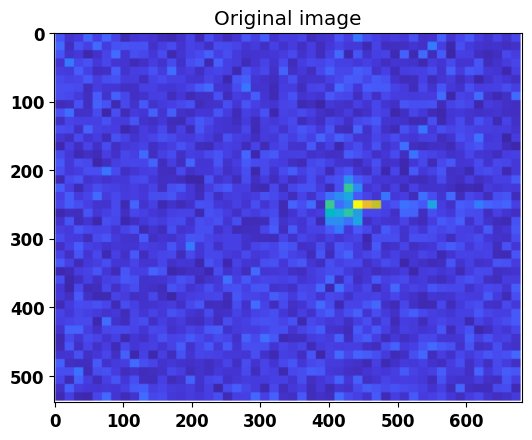

In [5]:
resize = (160, 160)

img = np.asarray(Image.open(x_train_dir + 'img_0.png'))

plt.imshow(img)
plt.title('Original image')

print('Image shape: ', img.shape)

### 2.3 Explore the labels

In [6]:
y_train = pd.read_csv(y_train_dir)
print(y_train.iloc[0:4])
print('y_train shape:', y_train.shape)
print('\ny_train unique values:', y_train['target'].unique())
print('labels:', len(y_train['target'].unique()))

   id  target
0   0       1
1   1       3
2   2       1
3   3       1
y_train shape: (8279, 2)

y_train unique values: [1 3 2]
labels: 3


## 3. Data preprocessing

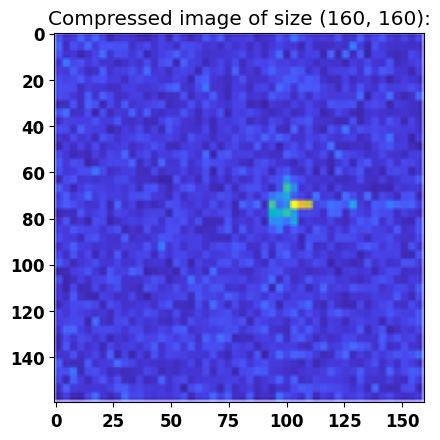

In [7]:
plt.imshow(np.asarray(Image.open(x_train_dir + 'img_0.png').resize(resize, Image.ANTIALIAS)))
plt.title('Compressed image of size ' + str(resize) + ':')
print()

### 3.1 x_train preprocessing

In [8]:
x_train_dir_filenames = os.listdir(x_train_dir)
x_train = []
for filename in x_train_dir_filenames:
  x_train.append(np.asarray(Image.open(x_train_dir + filename).resize(resize, Image.ANTIALIAS)))
x_train = np.array(x_train)
print(x_train.shape)

KeyboardInterrupt: ignored

#### Normalize x_train

In [ ]:
x_train = x_train.astype('float32')
x_train /= 255

#### Save x_train

In [ ]:
# save numpy array as npz file
from numpy import savez_compressed
# save to npy file
savez_compressed('/content/drive/MyDrive/x_train_160_compr_norm.npz', x_train)

#### Load x_train

In [8]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('/content/drive/MyDrive/x_train_160_compr_norm.npz')
# extract the first array
x_train = dict_data['arr_0']

### 3.2 x_test preprocessing

In [ ]:
x_test_dir_filenames = os.listdir(x_test_dir)
x_test = []
for filename in x_test_dir_filenames:
  x_test.append(np.asarray(Image.open(x_test_dir + filename).resize(resize, Image.ANTIALIAS)))
x_test = np.array(x_test)
print(x_test.shape)

#### Normalize x_train

In [ ]:
x_test = x_test.astype('float32')
x_test /= 255

#### Save x_test

In [ ]:
# save numpy array as npz file
from numpy import savez_compressed
# save to npy file
savez_compressed('/content/drive/MyDrive/x_test_160_compr_norm.npz', x_test)

#### Load x_test

In [9]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('/content/drive/MyDrive/x_test_160_compr_norm.npz')
# extract the first array
x_test = dict_data['arr_0']

### 3.3 y_train preprocessing

In [10]:
num_classes = len(y_train['target'].unique())
y_train_encoded = to_categorical(y_train['target'].values-1, num_classes).astype('int32')
print('"target" values as array: ', y_train['target'].values)
print('one-hot encoded: \n', y_train_encoded)

"target" values as array:  [1 3 1 ... 2 1 2]
one-hot encoded: 
 [[1 0 0]
 [0 0 1]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [0 1 0]]


## 4. CNN model

### 4.1 Build CNN model

In [11]:
input_shape = resize + (3, )

model = Sequential(
    [
        Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), padding='valid', activation="relu"),
        layers.Conv2D(32, kernel_size=(3, 3), padding='valid', activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), padding='valid', activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(500, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 156, 156, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 46208)             0

### 4.2 Train CNN model

In [12]:
callbacks = [
        EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=25,
        verbose=1)
]

In [13]:
batch_size = 128
epochs = 10

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.15, verbose=2)

Epoch 1/10
55/55 - 36s - loss: 1.1088 - accuracy: 0.4405 - val_loss: 1.0774 - val_accuracy: 0.4501 - 36s/epoch - 662ms/step
Epoch 2/10
55/55 - 11s - loss: 1.0716 - accuracy: 0.4527 - val_loss: 1.0713 - val_accuracy: 0.4501 - 11s/epoch - 201ms/step
Epoch 3/10
55/55 - 11s - loss: 1.0713 - accuracy: 0.4527 - val_loss: 1.0713 - val_accuracy: 0.4501 - 11s/epoch - 198ms/step
Epoch 4/10
55/55 - 11s - loss: 1.0707 - accuracy: 0.4532 - val_loss: 1.0750 - val_accuracy: 0.4501 - 11s/epoch - 202ms/step
Epoch 5/10
55/55 - 11s - loss: 1.0711 - accuracy: 0.4535 - val_loss: 1.0776 - val_accuracy: 0.4493 - 11s/epoch - 203ms/step
Epoch 6/10


KeyboardInterrupt: ignored

### 4.3 Evaluate trained CNN model

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('n epochs')
plt.ylabel('loss')

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('n epochs')
plt.ylabel('loss')

## 5. Model prediction

In [ ]:
y_pred_enc = model.predict(x_test)

ValueError: in user code:

    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\user\desktop\folders\study\python\vscodeprojects\dataanalysisfreecodecamp\.venv\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 128, 128, 3)


## 6. Export to CSV

In [ ]:
indexes = argmax(y_pred_enc, axis=1)
y_pred = indexes + 1

In [ ]:
y_pred_postpr = pd.DataFrame({'id': np.arange(0, len(y_pred)), 'target': y_pred})

In [ ]:
y_pred_postpr.to_csv('y_pred_mlp.csv', index=False)